<a href="https://colab.research.google.com/github/AdamChomicki/CNN/blob/main/CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
!git config --global user.email "ad.chomicki@gmail.com"
!git config --global user.name "AdamChomicki"

In [125]:
!git clone https://github.com/AdamChomicki/CNN.git

Cloning into 'CNN'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 780.55 KiB | 817.00 KiB/s, done.


In [145]:
!pwd

/content/CNN


In [132]:
%cd CNN

[Errno 2] No such file or directory: 'CNN'
/content/CNN


In [146]:
!ls

CNN_project_v1.ipynb		  Images.ipynb
createAugment_prepareModel.ipynb  Keras_Tuner.ipynb


In [151]:
!git remote -v

origin	https://github.com/AdamChomicki/CNN.git (fetch)
origin	https://github.com/AdamChomicki/CNN.git (push)


In [152]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [153]:
!git add .

In [154]:
!git commit -m 'With history_json'

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [158]:
!git push origin master

fatal: could not read Username for 'https://github.com': No such device or address


In [157]:
!git checkout -b master

Switched to a new branch 'master'


In [117]:
!pip install git+https://github.com/AdamChomicki/CNN.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdamChomicki/CNN.git to /tmp/pip-req-build-3aqvl96g
  Running command git clone --filter=blob:none --quiet https://github.com/AdamChomicki/CNN.git /tmp/pip-req-build-3aqvl96g
  Resolved https://github.com/AdamChomicki/CNN.git to commit 11b8fab3ee310b2647a75ace52a02d8d0de852e9
ERROR: git+https://github.com/AdamChomicki/CNN.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [122]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!pip install keras-tuner
import keras_tuner as kt

In [111]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import seaborn as sns
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D
from mpl_toolkits.axes_grid1 import ImageGrid
from google.colab.patches import cv2_imshow
from tensorflow import keras

In [5]:
base_dir = "/content/drive/MyDrive/Uczenie maszynowe/Projekty/Praca dyplomowa - mgr/img"

In [7]:
input_shape = (160,160,3)

### Data ingestion

In [8]:
def read_images(dir:str, input_shape:tuple):
  return np.array([cv2.resize(cv2.imread(os.path.join(dir, path)), input_shape[0:2]) for path in os.listdir(dir)])

df = read_images(os.path.join(base_dir), input_shape)
df.shape

(100, 160, 160, 3)

### Data divide

In [10]:
X_train, X_valid, X_test = np.split(df, [int(0.6*len(df)),int(0.8*len(df))])

In [11]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(60, 160, 160, 3)
(20, 160, 160, 3)
(20, 160, 160, 3)


### Viewing photos

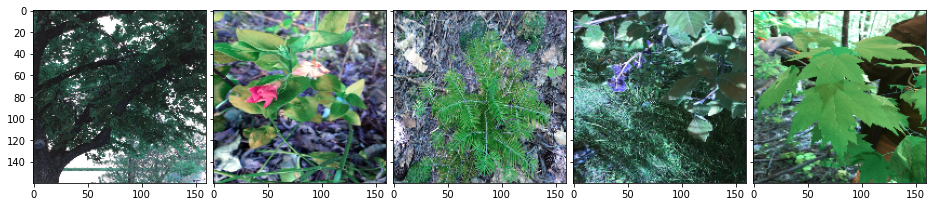

In [12]:
images = X_train[:5]

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,5),
                 axes_pad=0.1
                 )

for ax, image in zip(grid, images):
  ax.imshow(image)

plt.show()

### Model

In [13]:
class createAugment(keras.utils.Sequence):

    def __init__(self, X, y, batch_size=32, dim=(160, 160), n_channels=3, shuffle=True):
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        'Oznacza liczbę batchy na epokę'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generuje jeden batch danych'
        # Generuj indeksy batchy
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generuj dane
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Aktualizuj indeksy po każdej epoce'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        # Masked_images jest macierzą zamaskowanych obrazów używanych jako dane wejściowe
        Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Zamaskowany obraz
        # Mask_batch jest macierzą masek binarnych używanych jako dane wejściowe
        Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Maski binarne
        # y_batch jest macierzą oryginalnych obrazów używanych do obliczania błędu z zrekonstruowanego obrazu
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Obraz oryginalny

        ## Iteracja przez losowe indeksy
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Pobierz maskę związaną z tym obrazem
            masked_image, mask = self.__createMask(image_copy)

            Masked_images[i,] = masked_image / 255
            Mask_batch[i,] = mask / 255
            y_batch[i] = self.y[idx] / 255

        ## Return mask as well because partial convolution require the same.
        return [Masked_images, Mask_batch], y_batch

    def __createMask(self, img):
        ## Przygotuj maskującą macierz
        mask = np.full((*self.dim, 3), 255, np.uint8)  ## Białe tło
        for _ in range(np.random.randint(1, 10)):
            # Pobierz losowe lokalizacje x do linii startu
            x1, x2 = np.random.randint(1, self.dim[0]), np.random.randint(1, self.dim[0])
            # Pobierz losowe lokalizacje y do linii startu
            y1, y2 = np.random.randint(1, self.dim[1]), np.random.randint(1, self.dim[1])
            # Uzyskaj losową grubość rysowanej linii
            thickness = np.random.randint(1, 3)
            # Narysuj czarną linię na białej masce
            cv2.line(mask, (x1, y1), (x2, y2), (0, 0, 0), thickness)

        ## Maska zdjęcia
        masked_image = img.copy()
        masked_image[mask == 0] = 255

        return masked_image, mask

In [14]:
## Przygotowanie generatora par masek szkoleniowych i testowych obrazów

train_ds = createAugment(X_train, X_train, batch_size=8)
val_ds = createAugment(X_valid, X_valid, batch_size=8, shuffle=False)
test_ds = createAugment(X_test, X_test, batch_size=8, shuffle=False)

### Images with masks

In [15]:
corrupted_images = []
correct_images = []
sample_masks = []

ii = 0
for (corrupted, mask), reconstruction in train_ds:
  ii += 1
  corrupted_images.append(corrupted[0])
  correct_images.append(reconstruction[0])
  sample_masks.append(mask[0])
  if ii == 3:
    break

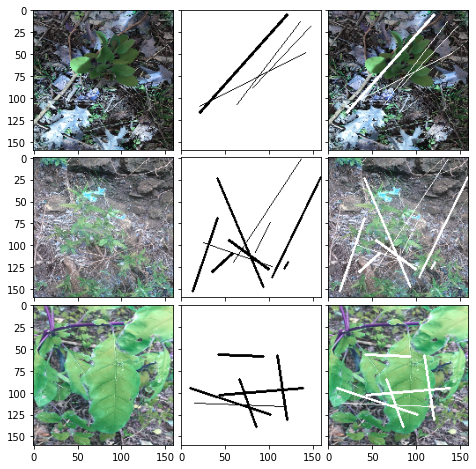

In [16]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3,3),
                 axes_pad=0.1
                 )

for idx, ax in enumerate(grid):
  if idx%3 == 0:
    ax.imshow(correct_images[idx//3])
  elif idx%3 == 1:
    ax.imshow(sample_masks[idx//3])
  else:
    ax.imshow(corrupted_images[idx//3])

plt.show()

In [17]:
class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Oblicz rozmiar wypełnienia, aby osiągnąć zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[0] - 1) / 2)),
            (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[0] - 1) / 2)),
        )

        # Rozmiar okna - używany do normalizacji
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        Będziemy używać metody Keras conv2d, i zasadniczo musimy
        pomnożenie maski przez dane wejściowe X, zanim zastosujemy
        konwolucji. Dla samej maski zastosujemy konwolucje z wszystkimi wagami
        ustawionymi na 1.
        Następnie przycinamy wartości maski do wartości pomiędzy 0 a 1
        '''

        # Należy dostarczyć zarówno obraz jak i maskę
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception(
                'PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Zastosuj konwolucje do maski
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Zastosuj konwolucje do obrazu
        img_output = K.conv2d(
            (images * masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Obliczanie współczynnika maski dla każdego piksela w masce wyjściowej
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Wyjście klipu ma być pomiędzy 0 a 1
        mask_output = K.clip(mask_output, 0, 1)

        # Usuń wartości współczynników, w których występują otwory
        mask_ratio = mask_ratio * mask_output

        # Normalizacja obrazu wyjściowego
        img_output = img_output * mask_ratio

        # Zastosuj bias tylko do obrazu (jeśli został wybrany)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Zastosuj aktywacje na obrazie
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Określa długość wyjściową konwolucji dla danej długości wejściowej.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [18]:
def __encoder_layer(filters, in_layer, in_mask):
 conv1, mask1 = PConv2D(160, (3,3), strides=1, padding='same')([in_layer, in_mask])
 conv1 = keras.activations.relu(conv1)

 conv2, mask2 = PConv2D(160, (3,3), strides=2, padding='same')([conv1, mask1])
 conv2 = keras.layers.BatchNormalization()(conv2, training=True)
 conv2 = keras.activations.relu(conv2)

 return conv1, mask1, conv2, mask2

In [19]:
def __decoder_layer( filter1, filter2, in_img, in_mask, share_img, share_mask):
 up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
 up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
 concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
 concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

 conv1, mask1 = PConv2D(filter1, (3,3), padding='same')([concat_img, concat_mask])
 conv1 = keras.activations.relu(conv1)

 conv2, mask2 = PConv2D(filter2, (3,3), padding='same')([conv1, mask1])
 conv2 = keras.layers.BatchNormalization()(conv2)
 conv2 = keras.activations.relu(conv2)

 return conv1, mask1, conv2, mask2

In [20]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [72]:
def prepare_model(hp):
    input_size = (160, 160, 3)
    input_image = keras.layers.Input(input_size, name="input_1")
    input_mask = keras.layers.Input(input_size, name="input_2")

    n_filters = hp.Int('n_filters', min_value=32, max_value=256, step=32)
    n_decoders = hp.Int('n_decoders', min_value=50, max_value=450, step=30)

    conv1, mask1, conv2, mask2 = __encoder_layer(n_filters, input_image, input_mask)
    conv3, mask3, conv4, mask4 = __encoder_layer(2 * n_filters, conv2, mask2)
    conv5, mask5, conv6, mask6 = __encoder_layer(4 * n_filters, conv4, mask4)
    conv7, mask7, conv8, mask8 = __encoder_layer(8 * n_filters, conv6, mask6)

    conv9, mask9, conv10, mask10 = __decoder_layer(8 * n_filters, 4 * n_decoders, conv8, mask8, conv7, mask7)
    conv11, mask11, conv12, mask12 = __decoder_layer(4 * n_filters, 2 * n_decoders, conv10, mask10, conv5, mask5)
    conv13, mask13, conv14, mask14 = __decoder_layer(2 * n_filters, n_decoders, conv12, mask12, conv3, mask3)
    conv15, mask15, conv16, mask16 = __decoder_layer(n_filters, 3, conv14, mask14, conv1, mask1)

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    model = keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=dice_coef,
                  metrics=['accuracy'])

    return model

### Keras Tuner

In [73]:
tuner = kt.BayesianOptimization(
    hypermodel=prepare_model,
    objective='val_loss',
    max_trials=3,
    seed=42,
    directory='/content/drive/MyDrive/Uczenie maszynowe/Projekty/Praca dyplomowa - mgr',
    project_name=("kerasTuner_result")
)

In [74]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [75]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stopping]
) 

### Results summary

In [76]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Uczenie maszynowe/Projekty/Praca dyplomowa - mgr/kerasTuner_result
Showing 10 best trials
Trial summary
Hyperparameters:
n_filters: 192
n_decoders: 50
Score: 0.43801000714302063
Trial summary
Hyperparameters:
n_filters: 128
n_decoders: 140
Score: 0.4391496777534485
Trial summary
Hyperparameters:
n_filters: 256
n_decoders: 170
Score: 0.44019046425819397


In [77]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [78]:
n_filters= best_hps.get('n_filters')
print(f'Number n_filters: {n_filters}')

Number n_filters: 192


In [79]:
n_decoders = best_hps.get('n_decoders')
print(f'Number n_decoders: {n_filters}')

Number n_decoders: 192


In [80]:
_best_hps = best_hps.values # Dlaczego 'result_summary' różni się od 'best_hps' ?
print(_best_hps)

{'n_filters': 192, 'n_decoders': 50}


### Saved result on disk

In [81]:
type(best_hps)

keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters

In [82]:
dict_best_hps = dict(best_hps.values)

In [83]:
print(dict_best_hps, type(dict_best_hps))

{'n_filters': 192, 'n_decoders': 50} <class 'dict'>


In [84]:
dir_with_result = './resultsHps'

In [85]:
if not os.path.exists(dir_with_result):
  os.mkdir(dir_with_result)

In [86]:
# to json

resultHps_json = '/content/resultsHps/resultHps.json'
with open(resultHps_json, mode='w') as f:
  print(dict_best_hps, file=f)

In [87]:
f = open('/content/resultsHps/result.txt', 'w')

with open('/content/resultsHps/result.txt','a') as f:
  print(dict_best_hps, file=f)

### Training

In [88]:
model = prepare_model(best_hps)

In [ ]:
model.predict(train_ds)

In [90]:
model.evaluate(train_ds)

7/7 [==============================] - 2s 214ms/step - loss: 0.4402 - accuracy: 0.1358


[0.4401799738407135, 0.1358112394809723]

In [91]:
history = model.fit(train_ds, validation_data = val_ds, epochs=3, callbacks=[early_stopping])

Epoch 1/3
7/7 [==============================] - 18s 827ms/step - loss: 0.4446 - accuracy: 0.1478 - val_loss: 0.4410 - val_accuracy: 0.0878
Epoch 2/3
7/7 [==============================] - 6s 805ms/step - loss: 0.4359 - accuracy: 0.1294 - val_loss: 0.4392 - val_accuracy: 0.0878
Epoch 3/3
7/7 [==============================] - 6s 808ms/step - loss: 0.4381 - accuracy: 0.1329 - val_loss: 0.4371 - val_accuracy: 0.0878


### Saved result on disk

In [92]:
dir_with_training = './resultsTraining'

In [93]:
if not os.path.exists(dir_with_training):
  os.mkdir(dir_with_training)

In [94]:
history_df = pd.DataFrame(history.history) 

In [95]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.444619,0.147751,0.441002,0.087795
1,0.435940,0.129389,0.439208,0.087795
2,0.438120,0.132925,0.437129,0.087795


In [96]:
# to json

history_json = '/content/resultsTraining/history.json'
with open(history_json, mode='w') as f:
  history_df.to_json(f)

In [97]:
# to csv

history_csv = '/content/resultsTraining/history.csv'
with open(history_csv, mode='w') as f:
  history_df.to_csv(f)

### Graphs

In [98]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

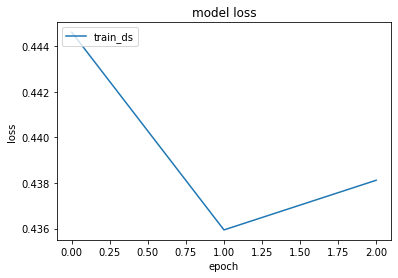

In [99]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_ds'], loc='upper left')
plt.show()

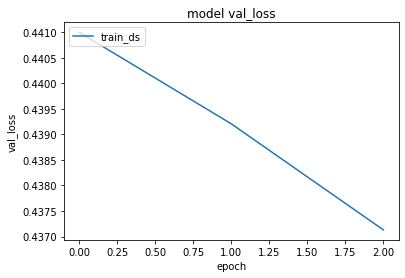

In [105]:
plt.plot(history.history['val_loss'])
plt.title('model val_loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train_ds'], loc='upper left')
plt.show()

<Axes: >

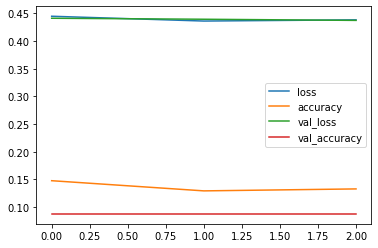

In [104]:
pd.DataFrame(history.history).plot()

In [108]:
def make_loss_plot(history):
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label='Strata walidacji', marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()

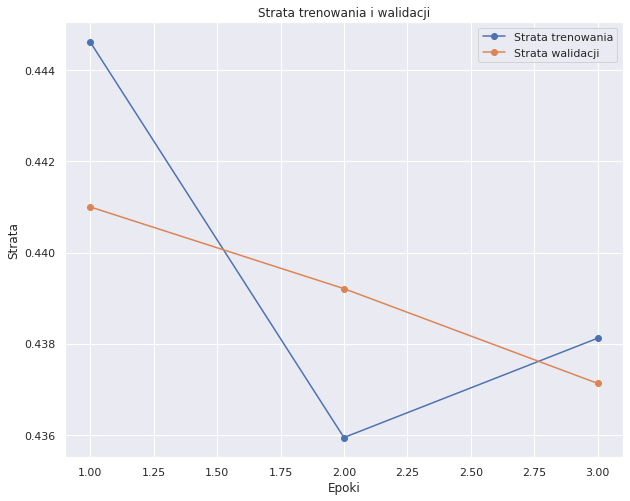

In [109]:
make_loss_plot(history)

In [110]:
predictions = model.predict(val_ds)

2/2 [==============================] - 0s 271ms/step


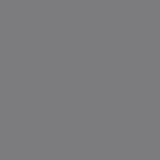

In [112]:
my_image = predictions[10]*255
image_resized = cv2.resize(my_image, (160,160))
cv2_imshow(image_resized)